In [73]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.signal import welch, butter, lfilter
import noisereduce as nr
from pydub import AudioSegment
from pydub.effects import normalize

d:\hack\pmifi-oniip-hack\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\hack\pmifi-oniip-hack\venv\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [74]:
import matplotlib.pyplot as plt

In [75]:
data_dir = '00000006.wav'

In [76]:
# Функция для удаления эха
def remove_echo(audio, sample_rate):
  # Преобразование в формат pydub
  audio_segment = AudioSegment(
      audio.tobytes(),
      frame_rate=sample_rate,
      sample_width=audio.dtype.itemsize,
      channels=1
  )
  # Нормализация и удаление эха
  audio_segment = normalize(audio_segment)
  return np.array(audio_segment.get_array_of_samples())

In [77]:
# Функции для удаления шумов (если понадобятся)
def butter_bandpass(lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return y

In [78]:
def reduce_noise(audio, sample_rate):
  return nr.reduce_noise(y=audio, sr=sample_rate) # новая функция, мб заменить

In [79]:
def nn_filter(mel):
    return librosa.decompose.nn_filter(mel)

In [83]:
# Функция для извлечения признаков
def extract_features(file_path):
  # Загрузка файла
  audio, sample_rate = librosa.load(file_path)
  # Эхоподавление
  # audio = remove_echo(audio, sample_rate).astype(np.float32) # а надо ли???
  # Удаление шума
  audio = reduce_noise(audio=audio, sample_rate=sample_rate)
  # Извлечение мелспектрограммы
  mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=40, fmax=8000)
  mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
  mel_features = np.mean(mel_spectrogram_db.T, axis=0)
  # Извлечение спектра Уэльса (PSD)
  freqs, psd = welch(audio, fs=sample_rate)
  psd_features = np.mean(psd)
  # Объединение признаков в один вектор
  combined_features = np.hstack((mel_features, psd_features))

  return combined_features

In [85]:
extract_features(file_path=data_dir).shape

(41,)

In [49]:
# Списки для хранения признаков и меток
features = []
labels = []

In [9]:
# for root, dirs, files in os.walk(data_dir):
#   for file in files:
#     if file.endswith('.wav'):
#       file_path = os.path.join(root, file)A
#       feature = extract_features(file_path)
#       if feature is not None:
#         features.append(feature)
#         labels.append(1 if 'abnormal' in file else 0)

In [10]:
# Нормализация данных
X = np.array(features)
y = np.array(labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [11]:
# Уменьшение размерности

pca = PCA(n_components=10) # не забыть выбрать количество компонент!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
X_pca = pca.fit_transform(X_scaled)

NameError: name 'X_scaled' is not defined

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

NameError: name 'X_pca' is not defined

In [13]:
0 - valve, 2 - pump, 4- fan, 6 - slider

NameError: name 'valve' is not defined

# Парсер + пца на мела

In [17]:
import os
import pandas as pd

root_dir = 'data'

data = []

name_mapping = {
    'valve': 0,
    'pump': 2,
    'fan': 4,
    'slider': 6
}

for db in os.listdir(root_dir):
  db_path = os.path.join(root_dir, db)
  if os.path.isdir(db_path):
    for name in os.listdir(db_path):
      name_path = os.path.join(db_path, name)
      if os.path.isdir(name_path):
        for id_ in os.listdir(name_path):
          id_path = os.path.join(name_path, id_)
          if os.path.isdir(id_path):
            for norm in os.listdir(id_path):
              norm_path = os.path.join(id_path, norm)
              if os.path.isdir(norm_path):
                for fn in os.listdir(norm_path):
                  if fn.endswith('.wav'):
                    is_norm_value = 0 if norm == 'abnormal' else 1
                    file_path = os.path.join(norm_path, fn)
                    features = extract_features(file_path)
                    data.append({
                      'db': db,
                      'chanel': name_mapping.get(name, name),  # Use the mapping
                      'id': id_,
                      'is_norm': is_norm_value,
                      'file_name': fn,
                      **{f'mel{i+1}': features[i] for i in range(len(features)-1)},
                      'psd': features[-1]
                    })

df = pd.DataFrame(data)

df

,db,chanel,id,is_norm,file_name,mel1,mel2,mel3,mel4,mel5,...,mel32,mel33,mel34,mel35,mel36,mel37,mel38,mel39,mel40,psd
0,db-6,4,id_00,0,00000000.wav,-46.456806,-46.578846,-48.761509,-48.653366,-48.911167,...,-65.304718,-63.306755,-61.551254,-62.820641,-64.996361,-64.987968,-63.576874,-65.653526,-65.803261,1.564354e-11
1,db-6,4,id_00,0,00000001.wav,-44.225758,-43.535175,-44.278908,-44.468216,-45.288219,...,-61.208874,-61.958885,-61.593849,-61.667046,-62.383312,-62.710072,-61.614468,-61.963165,-63.925438,7.983962e-12
2,db-6,4,id_00,0,00000002.wav,-47.693497,-50.621189,-47.872574,-46.445210,-46.472721,...,-53.333229,-54.874805,-55.387524,-55.807507,-55.197514,-56.446926,-57.410496,-58.105278,-60.939957,3.153391e-11
3,db-6,4,id_00,0,00000003.wav,-41.196163,-46.054543,-46.963692,-46.137032,-49.785816,...,-69.090607,-69.516319,-69.555237,-71.133217,-72.584343,-73.539673,-74.633469,-76.072609,-77.524361,1.399063e-11
4,db-6,4,id_00,0,00000004.wav,-41.935684,-45.101200,-42.961277,-41.684372,-41.640369,...,-43.482708,-42.643635,-44.869690,-48.000835,-49.605392,-48.607460,-42.403286,-42.915451,-50.570995,7.214685e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,db6,0,id_06,1,00000987.wav,-46.112213,-48.058151,-51.091801,-52.468170,-54.882923,...,-65.648010,-65.937195,-65.789703,-65.277786,-66.101860,-65.912682,-66.216057,-65.990219,-66.793312,9.925857e-11
54053,db6,0,id_06,1,00000988.wav,-48.354080,-49.909248,-52.686466,-55.317638,-56.898148,...,-66.033806,-66.317734,-66.147728,-65.532089,-66.400375,-66.366158,-66.849304,-66.638824,-67.366669,9.569085e-11
54054,db6,0,id_06,1,00000989.wav,-48.776165,-51.938610,-55.484730,-57.275696,-57.848263,...,-65.225136,-65.709633,-66.093224,-66.750816,-67.552185,-67.513748,-68.096832,-67.507370,-68.269096,9.764536e-11
54055,db6,0,id_06,1,00000990.wav,-49.387470,-50.271137,-53.753696,-58.999878,-60.096645,...,-65.221611,-66.249016,-66.232986,-65.767815,-66.567535,-65.208260,-65.822624,-66.511238,-67.407028,8.517963e-11


In [19]:
df.to_csv('data.csv', index=False)

In [40]:
num_mels = 40
num_pca = 10

mel_columns = [f'mel{i+1}' for i in range(num_mels)]
pca = PCA(n_components=num_pca)
pca_columns = [f'pca_mel{i+1}' for i in range(num_pca)]
df[pca_columns] = pca.fit_transform(df[mel_columns])
df = df.drop(columns=mel_columns)
df

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data.csv')
df

,db,chanel,id,is_norm,file_name,mel1,mel2,mel3,mel4,mel5,...,mel32,mel33,mel34,mel35,mel36,mel37,mel38,mel39,mel40,psd
0,db-6,4,id_00,0,00000000.wav,-46.456806,-46.578846,-48.761510,-48.653366,-48.911167,...,-65.304720,-63.306755,-61.551254,-62.820640,-64.996360,-64.987970,-63.576874,-65.653530,-65.803260,1.564354e-11
1,db-6,4,id_00,0,00000001.wav,-44.225758,-43.535175,-44.278908,-44.468216,-45.288220,...,-61.208874,-61.958885,-61.593850,-61.667046,-62.383312,-62.710070,-61.614468,-61.963165,-63.925438,7.983962e-12
2,db-6,4,id_00,0,00000002.wav,-47.693497,-50.621190,-47.872574,-46.445210,-46.472720,...,-53.333230,-54.874805,-55.387524,-55.807507,-55.197514,-56.446926,-57.410496,-58.105278,-60.939957,3.153391e-11
3,db-6,4,id_00,0,00000003.wav,-41.196163,-46.054543,-46.963690,-46.137030,-49.785816,...,-69.090610,-69.516320,-69.555240,-71.133220,-72.584340,-73.539670,-74.633470,-76.072610,-77.524360,1.399063e-11
4,db-6,4,id_00,0,00000004.wav,-41.935684,-45.101200,-42.961277,-41.684372,-41.640370,...,-43.482708,-42.643635,-44.869690,-48.000835,-49.605392,-48.607460,-42.403286,-42.915450,-50.570995,7.214685e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,db6,0,id_06,1,00000987.wav,-46.112213,-48.058150,-51.091800,-52.468170,-54.882923,...,-65.648010,-65.937195,-65.789700,-65.277790,-66.101860,-65.912680,-66.216060,-65.990220,-66.793310,9.925857e-11
54053,db6,0,id_06,1,00000988.wav,-48.354080,-49.909250,-52.686466,-55.317640,-56.898148,...,-66.033806,-66.317730,-66.147730,-65.532090,-66.400375,-66.366160,-66.849304,-66.638824,-67.366670,9.569085e-11
54054,db6,0,id_06,1,00000989.wav,-48.776165,-51.938610,-55.484730,-57.275696,-57.848263,...,-65.225136,-65.709630,-66.093220,-66.750820,-67.552185,-67.513750,-68.096830,-67.507370,-68.269100,9.764536e-11
54055,db6,0,id_06,1,00000990.wav,-49.387470,-50.271137,-53.753696,-58.999878,-60.096645,...,-65.221610,-66.249016,-66.232990,-65.767815,-66.567535,-65.208260,-65.822624,-66.511240,-67.407030,8.517963e-11


In [4]:
df['chanel'] = df['chanel'] / 2
df['chanel'].unique()

array([2., 1., 3., 0.])

In [5]:
df['chanel'] = df['chanel'].astype(int)
df

,db,chanel,id,is_norm,file_name,mel1,mel2,mel3,mel4,mel5,...,mel32,mel33,mel34,mel35,mel36,mel37,mel38,mel39,mel40,psd
0,db-6,2,id_00,0,00000000.wav,-46.456806,-46.578846,-48.761510,-48.653366,-48.911167,...,-65.304720,-63.306755,-61.551254,-62.820640,-64.996360,-64.987970,-63.576874,-65.653530,-65.803260,1.564354e-11
1,db-6,2,id_00,0,00000001.wav,-44.225758,-43.535175,-44.278908,-44.468216,-45.288220,...,-61.208874,-61.958885,-61.593850,-61.667046,-62.383312,-62.710070,-61.614468,-61.963165,-63.925438,7.983962e-12
2,db-6,2,id_00,0,00000002.wav,-47.693497,-50.621190,-47.872574,-46.445210,-46.472720,...,-53.333230,-54.874805,-55.387524,-55.807507,-55.197514,-56.446926,-57.410496,-58.105278,-60.939957,3.153391e-11
3,db-6,2,id_00,0,00000003.wav,-41.196163,-46.054543,-46.963690,-46.137030,-49.785816,...,-69.090610,-69.516320,-69.555240,-71.133220,-72.584340,-73.539670,-74.633470,-76.072610,-77.524360,1.399063e-11
4,db-6,2,id_00,0,00000004.wav,-41.935684,-45.101200,-42.961277,-41.684372,-41.640370,...,-43.482708,-42.643635,-44.869690,-48.000835,-49.605392,-48.607460,-42.403286,-42.915450,-50.570995,7.214685e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,db6,0,id_06,1,00000987.wav,-46.112213,-48.058150,-51.091800,-52.468170,-54.882923,...,-65.648010,-65.937195,-65.789700,-65.277790,-66.101860,-65.912680,-66.216060,-65.990220,-66.793310,9.925857e-11
54053,db6,0,id_06,1,00000988.wav,-48.354080,-49.909250,-52.686466,-55.317640,-56.898148,...,-66.033806,-66.317730,-66.147730,-65.532090,-66.400375,-66.366160,-66.849304,-66.638824,-67.366670,9.569085e-11
54054,db6,0,id_06,1,00000989.wav,-48.776165,-51.938610,-55.484730,-57.275696,-57.848263,...,-65.225136,-65.709630,-66.093220,-66.750820,-67.552185,-67.513750,-68.096830,-67.507370,-68.269100,9.764536e-11
54055,db6,0,id_06,1,00000990.wav,-49.387470,-50.271137,-53.753696,-58.999878,-60.096645,...,-65.221610,-66.249016,-66.232990,-65.767815,-66.567535,-65.208260,-65.822624,-66.511240,-67.407030,8.517963e-11


In [6]:
X = df.drop(columns=['db', 'chanel', 'id', 'is_norm', 'file_name'])
y = df['chanel']

In [7]:
X

,mel1,mel2,mel3,mel4,mel5,mel6,mel7,mel8,mel9,mel10,...,mel32,mel33,mel34,mel35,mel36,mel37,mel38,mel39,mel40,psd
0,-46.456806,-46.578846,-48.761510,-48.653366,-48.911167,-46.321510,-49.737526,-52.872750,-54.858280,-53.560253,...,-65.304720,-63.306755,-61.551254,-62.820640,-64.996360,-64.987970,-63.576874,-65.653530,-65.803260,1.564354e-11
1,-44.225758,-43.535175,-44.278908,-44.468216,-45.288220,-46.220093,-43.773357,-45.187084,-40.110290,-48.048157,...,-61.208874,-61.958885,-61.593850,-61.667046,-62.383312,-62.710070,-61.614468,-61.963165,-63.925438,7.983962e-12
2,-47.693497,-50.621190,-47.872574,-46.445210,-46.472720,-45.842228,-45.380474,-48.271480,-49.443040,-49.310234,...,-53.333230,-54.874805,-55.387524,-55.807507,-55.197514,-56.446926,-57.410496,-58.105278,-60.939957,3.153391e-11
3,-41.196163,-46.054543,-46.963690,-46.137030,-49.785816,-50.619263,-49.360283,-50.372135,-52.959198,-53.213078,...,-69.090610,-69.516320,-69.555240,-71.133220,-72.584340,-73.539670,-74.633470,-76.072610,-77.524360,1.399063e-11
4,-41.935684,-45.101200,-42.961277,-41.684372,-41.640370,-41.523888,-42.465454,-41.976925,-43.022140,-45.014275,...,-43.482708,-42.643635,-44.869690,-48.000835,-49.605392,-48.607460,-42.403286,-42.915450,-50.570995,7.214685e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,-46.112213,-48.058150,-51.091800,-52.468170,-54.882923,-56.856846,-57.253690,-58.287876,-60.022236,-59.514637,...,-65.648010,-65.937195,-65.789700,-65.277790,-66.101860,-65.912680,-66.216060,-65.990220,-66.793310,9.925857e-11
54053,-48.354080,-49.909250,-52.686466,-55.317640,-56.898148,-58.401104,-58.528110,-59.721640,-61.540420,-61.090054,...,-66.033806,-66.317730,-66.147730,-65.532090,-66.400375,-66.366160,-66.849304,-66.638824,-67.366670,9.569085e-11
54054,-48.776165,-51.938610,-55.484730,-57.275696,-57.848263,-58.825504,-59.422680,-59.717840,-60.123875,-60.311710,...,-65.225136,-65.709630,-66.093220,-66.750820,-67.552185,-67.513750,-68.096830,-67.507370,-68.269100,9.764536e-11
54055,-49.387470,-50.271137,-53.753696,-58.999878,-60.096645,-60.613650,-59.911560,-59.645367,-61.446117,-61.534800,...,-65.221610,-66.249016,-66.232990,-65.767815,-66.567535,-65.208260,-65.822624,-66.511240,-67.407030,8.517963e-11


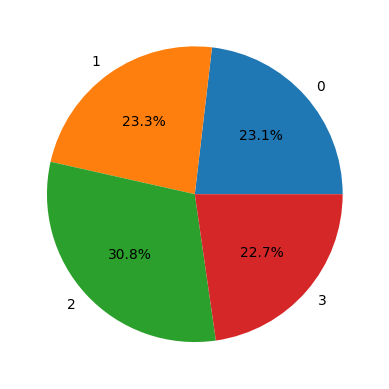

In [12]:
names, counts = np.unique(y, return_counts=True)
plt.pie(counts, labels=names, autopct='%1.1f%%');

## 1.1 Разделение данных на обучение и тест

In [4]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

## 1.2 Скалирование данных

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### 1.2.1 StandardScaler

In [17]:
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)

In [18]:
X_test_std = std_scaler.transform(X_test)

### 1.2.2 MinMaxScaler

In [19]:
min_max_scaler = MinMaxScaler()
X_train_min_max = min_max_scaler.fit_transform(X_train)

In [20]:
X_test_min_max = min_max_scaler.transform(X_test)

## 1.3 Обучение и предсказание

In [21]:
from sklearn.metrics import classification_report

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [30]:
num_pca = 10

pca = PCA(n_components=num_pca)
X_train_pca = pca.fit_transform(X_train)

In [31]:
X_test_pca = pca.transform(X_test)

### 1.3.1 Без подбора гиперпараметров

In [59]:
knn = KNeighborsClassifier(11).fit(X_train, y_train)

pred = knn.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2542
           1       0.82      0.85      0.83      2431
           2       0.91      0.84      0.88      3587
           3       0.83      0.90      0.86      2252

    accuracy                           0.86     10812
   macro avg       0.86      0.86      0.86     10812
weighted avg       0.86      0.86      0.86     10812



In [32]:
knn_pca = KNeighborsClassifier(11).fit(X_train_pca, y_train)

pred = knn_pca.predict(X_test_pca)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      2629
           1       0.72      0.74      0.73      2434
           2       0.85      0.82      0.84      3463
           3       0.77      0.82      0.79      2286

    accuracy                           0.80     10812
   macro avg       0.79      0.79      0.79     10812
weighted avg       0.80      0.80      0.80     10812



In [53]:
knn_std = KNeighborsClassifier(11).fit(X_train_std, y_train)

pred = knn_std.predict(X_test_std)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2494
           1       0.84      0.85      0.85      2474
           2       0.92      0.86      0.89      3574
           3       0.84      0.90      0.87      2270

    accuracy                           0.87     10812
   macro avg       0.87      0.88      0.87     10812
weighted avg       0.88      0.87      0.87     10812



In [33]:
std_scaler_pca = StandardScaler()
X_train_std_pca = std_scaler_pca.fit_transform(X_train_pca)

In [34]:
X_test_std_pca = std_scaler_pca.transform(X_test_pca)

In [35]:
knn_pca_std = KNeighborsClassifier(11).fit(X_train_std_pca, y_train)

pred = knn_pca_std.predict(X_test_std_pca)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2643
           1       0.76      0.80      0.78      2371
           2       0.89      0.84      0.87      3512
           3       0.81      0.87      0.84      2286

    accuracy                           0.83     10812
   macro avg       0.83      0.83      0.83     10812
weighted avg       0.83      0.83      0.83     10812



In [57]:
knn_min_max = KNeighborsClassifier(11).fit(X_train_min_max, y_train)

pred = knn_min_max.predict(X_test_min_max)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2550
           1       0.82      0.85      0.83      2441
           2       0.91      0.85      0.88      3567
           3       0.83      0.91      0.87      2254

    accuracy                           0.86     10812
   macro avg       0.86      0.86      0.86     10812
weighted avg       0.86      0.86      0.86     10812



### 1.3.2 Без подбора гиперпараметров

In [23]:
from sklearn.model_selection import GridSearchCV

In [25]:
knn_grid = {
    'n_neighbors': range(11, 19, 2),
    'p': range(1, 3)
}

knn = GridSearchCV(KNeighborsClassifier(), knn_grid).fit(X_train, y_train).best_estimator_

pred = knn.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2524
           1       0.82      0.84      0.83      2460
           2       0.91      0.84      0.88      3586
           3       0.83      0.91      0.87      2242

    accuracy                           0.86     10812
   macro avg       0.86      0.86      0.86     10812
weighted avg       0.86      0.86      0.86     10812



In [26]:
knn_std = GridSearchCV(KNeighborsClassifier(), knn_grid).fit(X_train_std, y_train).best_estimator_

pred = knn_std.predict(X_test_std)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2445
           1       0.85      0.86      0.85      2504
           2       0.92      0.85      0.89      3615
           3       0.84      0.92      0.88      2248

    accuracy                           0.88     10812
   macro avg       0.88      0.88      0.88     10812
weighted avg       0.88      0.88      0.88     10812



In [27]:
knn_min_max = GridSearchCV(KNeighborsClassifier(), knn_grid).fit(X_train_min_max, y_train).best_estimator_

pred = knn_min_max.predict(X_test_min_max)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2519
           1       0.83      0.85      0.84      2469
           2       0.91      0.85      0.88      3585
           3       0.83      0.91      0.87      2239

    accuracy                           0.86     10812
   macro avg       0.86      0.87      0.86     10812
weighted avg       0.87      0.86      0.86     10812



_______________________________

In [50]:
# Функция для извлечения признаков
def extract_features(file_path, chanel=None):
  # Загрузка файла
  if not chanel:
    mono = True
  else: 
    mono=False
  audio, sample_rate = librosa.load(file_path, mono=mono)
  if chanel:
    audio = audio[chanel]
  # Эхоподавление
  audio = remove_echo(audio, sample_rate).astype(np.float32) # а надо ли???
  # Удаление шума
  audio = reduce_noise(audio=audio, sample_rate=sample_rate)
  # Извлечение мелспектрограммы
  mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=40, fmax=8000)
  mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
  mel_features = np.mean(mel_spectrogram_db.T, axis=0)
  # Извлечение спектра Уэльса (PSD)
  freqs, psd = welch(audio, fs=sample_rate)
  psd_features = np.mean(psd)
  # Объединение признаков в один вектор
  combined_features = np.hstack((mel_features, psd_features))

  return combined_features

In [51]:
import os
import pandas as pd
import tqdm
import librosa

root_dir = 'data'

data = []

name_mapping = {
    'valve': 0,
    'pump': 2,
    'fan': 4,
    'slider': 6
}

for db in tqdm.tqdm(os.listdir(root_dir)):
  db_path = os.path.join(root_dir, db)
  if os.path.isdir(db_path):
    for name in os.listdir(db_path):
      name_path = os.path.join(db_path, name)
      if os.path.isdir(name_path):
        for id_ in os.listdir(name_path):
          id_path = os.path.join(name_path, id_)
          if os.path.isdir(id_path):
            for norm in os.listdir(id_path):
              norm_path = os.path.join(id_path, norm)
              if os.path.isdir(norm_path):
                for fn in os.listdir(norm_path):
                  if fn.endswith('.wav'):
                    is_norm_value = 0 if norm == 'abnormal' else 1
                    file_path = os.path.join(norm_path, fn)
                    chanel = name_mapping.get(name, name)
                    features = extract_features(file_path, chanel)
                    data.append({
                      'db': db,
                      'chanel': chanel,
                      'id': id_,
                      'is_norm': is_norm_value,
                      'file_name': fn,
                      **{f'mel{i+1}': features[i] for i in range(len(features)-1)},
                      'psd': features[-1]
                    })

df = pd.DataFrame(data)

df

100%|██████████| 3/3 [3:22:48<00:00, 4056.06s/it]  


,db,chanel,id,is_norm,file_name,mel1,mel2,mel3,mel4,mel5,...,mel32,mel33,mel34,mel35,mel36,mel37,mel38,mel39,mel40,psd
0,db-6,4,id_00,0,00000000.wav,-40.180298,-42.879349,-46.631409,-48.344250,-48.083191,...,-49.994270,-50.667599,-50.117710,-50.134567,-51.627537,-50.639229,-49.395302,-49.402100,-50.387753,4.340077e+11
1,db-6,4,id_00,0,00000001.wav,-40.473091,-42.214691,-43.820148,-45.143673,-45.350784,...,-49.289154,-49.495323,-48.677753,-46.850021,-48.109085,-48.257278,-48.533272,-48.933674,-49.331741,3.563414e+11
2,db-6,4,id_00,0,00000002.wav,-38.085461,-42.228130,-41.691738,-41.495800,-41.090115,...,-43.935131,-43.877754,-43.342201,-41.941456,-41.827938,-43.065876,-43.521648,-43.335938,-43.502365,5.625710e+11
3,db-6,4,id_00,0,00000003.wav,-32.248611,-35.452465,-36.363228,-36.646709,-40.451488,...,-49.115139,-48.525414,-47.800854,-48.458622,-48.806816,-48.574745,-48.834629,-49.440002,-50.276672,3.765741e+11
4,db-6,4,id_00,0,00000004.wav,-40.775566,-44.054714,-43.297890,-42.072315,-41.688808,...,-37.364498,-37.395592,-38.206966,-40.326992,-41.306843,-39.604408,-34.214886,-35.095119,-40.066788,4.125696e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,db6,0,id_06,1,00000987.wav,-33.519360,-34.026779,-35.607254,-35.175339,-37.096878,...,-48.485989,-49.707626,-50.144367,-50.295860,-51.777802,-52.011627,-52.120495,-52.582687,-52.626396,8.196626e+11
54053,db6,0,id_06,1,00000988.wav,-30.698603,-31.018648,-32.282318,-33.051487,-34.076286,...,-47.106911,-48.118504,-48.294762,-49.617939,-49.626423,-49.746941,-50.583302,-51.177792,-51.306343,9.592131e+11
54054,db6,0,id_06,1,00000989.wav,-33.624172,-35.562992,-37.332245,-38.387249,-38.560905,...,-47.303539,-47.306618,-47.370907,-46.316605,-46.670635,-47.142910,-47.829884,-48.221813,-47.437111,5.561422e+11
54055,db6,0,id_06,1,00000990.wav,-32.240273,-31.098295,-33.479446,-37.277576,-37.959518,...,-44.119289,-45.211613,-46.225552,-44.917641,-44.358513,-45.138992,-45.223675,-45.878529,-46.504189,6.457283e+11


In [52]:
df.to_csv('data2.csv', index=False)

___________________

In [1]:
import tensorflow.keras as k
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('data2.csv')
df

,db,chanel,id,is_norm,file_name,mel1,mel2,mel3,mel4,mel5,...,mel32,mel33,mel34,mel35,mel36,mel37,mel38,mel39,mel40,psd
0,db-6,4,id_00,0,00000000.wav,-40.180298,-42.879350,-46.631410,-48.344250,-48.083190,...,-49.994270,-50.667600,-50.117710,-50.134567,-51.627537,-50.639230,-49.395300,-49.402100,-50.387753,4.340077e+11
1,db-6,4,id_00,0,00000001.wav,-40.473090,-42.214690,-43.820150,-45.143673,-45.350784,...,-49.289154,-49.495323,-48.677753,-46.850020,-48.109085,-48.257280,-48.533270,-48.933674,-49.331740,3.563414e+11
2,db-6,4,id_00,0,00000002.wav,-38.085460,-42.228130,-41.691740,-41.495800,-41.090115,...,-43.935130,-43.877754,-43.342200,-41.941456,-41.827938,-43.065876,-43.521650,-43.335938,-43.502365,5.625710e+11
3,db-6,4,id_00,0,00000003.wav,-32.248610,-35.452465,-36.363228,-36.646710,-40.451490,...,-49.115140,-48.525414,-47.800854,-48.458622,-48.806816,-48.574745,-48.834630,-49.440002,-50.276672,3.765742e+11
4,db-6,4,id_00,0,00000004.wav,-40.775566,-44.054714,-43.297890,-42.072315,-41.688810,...,-37.364500,-37.395590,-38.206966,-40.326992,-41.306843,-39.604410,-34.214886,-35.095120,-40.066788,4.125696e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,db6,0,id_06,1,00000987.wav,-33.519360,-34.026780,-35.607254,-35.175340,-37.096878,...,-48.485990,-49.707626,-50.144367,-50.295860,-51.777800,-52.011627,-52.120495,-52.582687,-52.626396,8.196626e+11
54053,db6,0,id_06,1,00000988.wav,-30.698603,-31.018648,-32.282320,-33.051487,-34.076286,...,-47.106910,-48.118504,-48.294760,-49.617940,-49.626423,-49.746940,-50.583300,-51.177790,-51.306343,9.592131e+11
54054,db6,0,id_06,1,00000989.wav,-33.624172,-35.562992,-37.332245,-38.387250,-38.560905,...,-47.303540,-47.306618,-47.370907,-46.316605,-46.670635,-47.142910,-47.829884,-48.221813,-47.437110,5.561422e+11
54055,db6,0,id_06,1,00000990.wav,-32.240273,-31.098295,-33.479446,-37.277576,-37.959520,...,-44.119290,-45.211613,-46.225550,-44.917640,-44.358513,-45.138992,-45.223675,-45.878530,-46.504190,6.457283e+11


In [3]:
df = df.drop(columns=['db', 'id', 'file_name'])
df

,chanel,is_norm,mel1,mel2,mel3,mel4,mel5,mel6,mel7,mel8,...,mel32,mel33,mel34,mel35,mel36,mel37,mel38,mel39,mel40,psd
0,4,0,-40.180298,-42.879350,-46.631410,-48.344250,-48.083190,-45.080490,-46.108097,-46.516155,...,-49.994270,-50.667600,-50.117710,-50.134567,-51.627537,-50.639230,-49.395300,-49.402100,-50.387753,4.340077e+11
1,4,0,-40.473090,-42.214690,-43.820150,-45.143673,-45.350784,-45.099712,-42.915130,-43.239094,...,-49.289154,-49.495323,-48.677753,-46.850020,-48.109085,-48.257280,-48.533270,-48.933674,-49.331740,3.563414e+11
2,4,0,-38.085460,-42.228130,-41.691740,-41.495800,-41.090115,-40.266357,-39.834850,-41.956577,...,-43.935130,-43.877754,-43.342200,-41.941456,-41.827938,-43.065876,-43.521650,-43.335938,-43.502365,5.625710e+11
3,4,0,-32.248610,-35.452465,-36.363228,-36.646710,-40.451490,-41.519550,-41.529130,-42.286045,...,-49.115140,-48.525414,-47.800854,-48.458622,-48.806816,-48.574745,-48.834630,-49.440002,-50.276672,3.765742e+11
4,4,0,-40.775566,-44.054714,-43.297890,-42.072315,-41.688810,-41.992546,-42.219420,-41.867530,...,-37.364500,-37.395590,-38.206966,-40.326992,-41.306843,-39.604410,-34.214886,-35.095120,-40.066788,4.125696e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,0,1,-33.519360,-34.026780,-35.607254,-35.175340,-37.096878,-39.144290,-40.537632,-41.854992,...,-48.485990,-49.707626,-50.144367,-50.295860,-51.777800,-52.011627,-52.120495,-52.582687,-52.626396,8.196626e+11
54053,0,1,-30.698603,-31.018648,-32.282320,-33.051487,-34.076286,-35.285570,-36.671337,-38.685383,...,-47.106910,-48.118504,-48.294760,-49.617940,-49.626423,-49.746940,-50.583300,-51.177790,-51.306343,9.592131e+11
54054,0,1,-33.624172,-35.562992,-37.332245,-38.387250,-38.560905,-39.384014,-40.957510,-41.328465,...,-47.303540,-47.306618,-47.370907,-46.316605,-46.670635,-47.142910,-47.829884,-48.221813,-47.437110,5.561422e+11
54055,0,1,-32.240273,-31.098295,-33.479446,-37.277576,-37.959520,-39.525414,-40.980797,-42.809372,...,-44.119290,-45.211613,-46.225550,-44.917640,-44.358513,-45.138992,-45.223675,-45.878530,-46.504190,6.457283e+11


In [4]:
df['chanel'] /= 2
df

,chanel,is_norm,mel1,mel2,mel3,mel4,mel5,mel6,mel7,mel8,...,mel32,mel33,mel34,mel35,mel36,mel37,mel38,mel39,mel40,psd
0,2.0,0,-40.180298,-42.879350,-46.631410,-48.344250,-48.083190,-45.080490,-46.108097,-46.516155,...,-49.994270,-50.667600,-50.117710,-50.134567,-51.627537,-50.639230,-49.395300,-49.402100,-50.387753,4.340077e+11
1,2.0,0,-40.473090,-42.214690,-43.820150,-45.143673,-45.350784,-45.099712,-42.915130,-43.239094,...,-49.289154,-49.495323,-48.677753,-46.850020,-48.109085,-48.257280,-48.533270,-48.933674,-49.331740,3.563414e+11
2,2.0,0,-38.085460,-42.228130,-41.691740,-41.495800,-41.090115,-40.266357,-39.834850,-41.956577,...,-43.935130,-43.877754,-43.342200,-41.941456,-41.827938,-43.065876,-43.521650,-43.335938,-43.502365,5.625710e+11
3,2.0,0,-32.248610,-35.452465,-36.363228,-36.646710,-40.451490,-41.519550,-41.529130,-42.286045,...,-49.115140,-48.525414,-47.800854,-48.458622,-48.806816,-48.574745,-48.834630,-49.440002,-50.276672,3.765742e+11
4,2.0,0,-40.775566,-44.054714,-43.297890,-42.072315,-41.688810,-41.992546,-42.219420,-41.867530,...,-37.364500,-37.395590,-38.206966,-40.326992,-41.306843,-39.604410,-34.214886,-35.095120,-40.066788,4.125696e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,0.0,1,-33.519360,-34.026780,-35.607254,-35.175340,-37.096878,-39.144290,-40.537632,-41.854992,...,-48.485990,-49.707626,-50.144367,-50.295860,-51.777800,-52.011627,-52.120495,-52.582687,-52.626396,8.196626e+11
54053,0.0,1,-30.698603,-31.018648,-32.282320,-33.051487,-34.076286,-35.285570,-36.671337,-38.685383,...,-47.106910,-48.118504,-48.294760,-49.617940,-49.626423,-49.746940,-50.583300,-51.177790,-51.306343,9.592131e+11
54054,0.0,1,-33.624172,-35.562992,-37.332245,-38.387250,-38.560905,-39.384014,-40.957510,-41.328465,...,-47.303540,-47.306618,-47.370907,-46.316605,-46.670635,-47.142910,-47.829884,-48.221813,-47.437110,5.561422e+11
54055,0.0,1,-32.240273,-31.098295,-33.479446,-37.277576,-37.959520,-39.525414,-40.980797,-42.809372,...,-44.119290,-45.211613,-46.225550,-44.917640,-44.358513,-45.138992,-45.223675,-45.878530,-46.504190,6.457283e+11


In [5]:
df['is_norm'] = -1 * df['is_norm'] + 1
df.rename(columns={'is_norm': 'is_anomal'}, inplace=True)
df

,chanel,is_anomal,mel1,mel2,mel3,mel4,mel5,mel6,mel7,mel8,...,mel32,mel33,mel34,mel35,mel36,mel37,mel38,mel39,mel40,psd
0,2.0,1,-40.180298,-42.879350,-46.631410,-48.344250,-48.083190,-45.080490,-46.108097,-46.516155,...,-49.994270,-50.667600,-50.117710,-50.134567,-51.627537,-50.639230,-49.395300,-49.402100,-50.387753,4.340077e+11
1,2.0,1,-40.473090,-42.214690,-43.820150,-45.143673,-45.350784,-45.099712,-42.915130,-43.239094,...,-49.289154,-49.495323,-48.677753,-46.850020,-48.109085,-48.257280,-48.533270,-48.933674,-49.331740,3.563414e+11
2,2.0,1,-38.085460,-42.228130,-41.691740,-41.495800,-41.090115,-40.266357,-39.834850,-41.956577,...,-43.935130,-43.877754,-43.342200,-41.941456,-41.827938,-43.065876,-43.521650,-43.335938,-43.502365,5.625710e+11
3,2.0,1,-32.248610,-35.452465,-36.363228,-36.646710,-40.451490,-41.519550,-41.529130,-42.286045,...,-49.115140,-48.525414,-47.800854,-48.458622,-48.806816,-48.574745,-48.834630,-49.440002,-50.276672,3.765742e+11
4,2.0,1,-40.775566,-44.054714,-43.297890,-42.072315,-41.688810,-41.992546,-42.219420,-41.867530,...,-37.364500,-37.395590,-38.206966,-40.326992,-41.306843,-39.604410,-34.214886,-35.095120,-40.066788,4.125696e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,0.0,0,-33.519360,-34.026780,-35.607254,-35.175340,-37.096878,-39.144290,-40.537632,-41.854992,...,-48.485990,-49.707626,-50.144367,-50.295860,-51.777800,-52.011627,-52.120495,-52.582687,-52.626396,8.196626e+11
54053,0.0,0,-30.698603,-31.018648,-32.282320,-33.051487,-34.076286,-35.285570,-36.671337,-38.685383,...,-47.106910,-48.118504,-48.294760,-49.617940,-49.626423,-49.746940,-50.583300,-51.177790,-51.306343,9.592131e+11
54054,0.0,0,-33.624172,-35.562992,-37.332245,-38.387250,-38.560905,-39.384014,-40.957510,-41.328465,...,-47.303540,-47.306618,-47.370907,-46.316605,-46.670635,-47.142910,-47.829884,-48.221813,-47.437110,5.561422e+11
54055,0.0,0,-32.240273,-31.098295,-33.479446,-37.277576,-37.959520,-39.525414,-40.980797,-42.809372,...,-44.119290,-45.211613,-46.225550,-44.917640,-44.358513,-45.138992,-45.223675,-45.878530,-46.504190,6.457283e+11


In [6]:
df['chanel'] = df['chanel'].astype(int)
df

,chanel,is_anomal,mel1,mel2,mel3,mel4,mel5,mel6,mel7,mel8,...,mel32,mel33,mel34,mel35,mel36,mel37,mel38,mel39,mel40,psd
0,2,1,-40.180298,-42.879350,-46.631410,-48.344250,-48.083190,-45.080490,-46.108097,-46.516155,...,-49.994270,-50.667600,-50.117710,-50.134567,-51.627537,-50.639230,-49.395300,-49.402100,-50.387753,4.340077e+11
1,2,1,-40.473090,-42.214690,-43.820150,-45.143673,-45.350784,-45.099712,-42.915130,-43.239094,...,-49.289154,-49.495323,-48.677753,-46.850020,-48.109085,-48.257280,-48.533270,-48.933674,-49.331740,3.563414e+11
2,2,1,-38.085460,-42.228130,-41.691740,-41.495800,-41.090115,-40.266357,-39.834850,-41.956577,...,-43.935130,-43.877754,-43.342200,-41.941456,-41.827938,-43.065876,-43.521650,-43.335938,-43.502365,5.625710e+11
3,2,1,-32.248610,-35.452465,-36.363228,-36.646710,-40.451490,-41.519550,-41.529130,-42.286045,...,-49.115140,-48.525414,-47.800854,-48.458622,-48.806816,-48.574745,-48.834630,-49.440002,-50.276672,3.765742e+11
4,2,1,-40.775566,-44.054714,-43.297890,-42.072315,-41.688810,-41.992546,-42.219420,-41.867530,...,-37.364500,-37.395590,-38.206966,-40.326992,-41.306843,-39.604410,-34.214886,-35.095120,-40.066788,4.125696e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,0,0,-33.519360,-34.026780,-35.607254,-35.175340,-37.096878,-39.144290,-40.537632,-41.854992,...,-48.485990,-49.707626,-50.144367,-50.295860,-51.777800,-52.011627,-52.120495,-52.582687,-52.626396,8.196626e+11
54053,0,0,-30.698603,-31.018648,-32.282320,-33.051487,-34.076286,-35.285570,-36.671337,-38.685383,...,-47.106910,-48.118504,-48.294760,-49.617940,-49.626423,-49.746940,-50.583300,-51.177790,-51.306343,9.592131e+11
54054,0,0,-33.624172,-35.562992,-37.332245,-38.387250,-38.560905,-39.384014,-40.957510,-41.328465,...,-47.303540,-47.306618,-47.370907,-46.316605,-46.670635,-47.142910,-47.829884,-48.221813,-47.437110,5.561422e+11
54055,0,0,-32.240273,-31.098295,-33.479446,-37.277576,-37.959520,-39.525414,-40.980797,-42.809372,...,-44.119290,-45.211613,-46.225550,-44.917640,-44.358513,-45.138992,-45.223675,-45.878530,-46.504190,6.457283e+11


In [7]:
grouped_df = df.groupby(['chanel'])
grouped_df.apply(lambda x: x.reset_index(drop=True))

C:\Users\bugae\AppData\Local\Temp\ipykernel_2980\2097935400.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_df.apply(lambda x: x.reset_index(drop=True))


chanel  is_anomal       mel1       mel2       mel3       mel4  \
chanel                                                                        
0      0           0          1 -38.104244 -37.921240 -38.078117 -38.292988   
       1           0          1 -41.600258 -37.528023 -40.895416 -43.125410   
       2           0          1 -45.270950 -37.069100 -41.531994 -44.097183   
       3           0          1 -39.551260 -36.683250 -38.798542 -41.514690   
       4           0          1 -46.594463 -42.616753 -43.421837 -45.407616   
...              ...        ...        ...        ...        ...        ...   
3      12277       3          0 -37.148876 -34.184597 -34.379670 -32.004772   
       12278       3          0 -36.475560 -34.133530 -32.468630 -29.767374   
       12279       3          0 -37.362087 -32.350260 -31.877617 -29.982000   
       12280       3          0 -37.290930 -35.731815 -33.389970 -30.128160   
       12281       3          0 -38.448240 -35.449955 -35.230160 -31.264610   

                   mel5       mel6       mel7       mel8  ...      mel32  \
chanel                                                    ...              
0      0     -39.973200 -41.242695 -42.533220 -43.689053  ... -49.608776   
       1     -43.588646 -42.658714 -43.328194 -42.239098  ... -53.063297   
       2     -44.007263 -45.944088 -46.478683 -46.484444  ... -51.846820   
       3     -44.083220 -41.770668 -39.764946 -39.356440  ... -46.295574   
       4     -46.034485 -44.772380 -41.973564 -33.908726  ... -49.340680   
...                 ...        ...        ...        ...  ...        ...   
3      12277 -31.057844 -35.278570 -40.431076 -44.256300  ... -52.587887   
       12278 -28.445532 -32.553860 -36.219960 -40.407936  ... -51.816860   
       12279 -29.204182 -33.414620 -39.526855 -43.643417  ... -51.723564   
       12280 -29.638092 -33.672318 -37.199276 -41.087585  ... -49.643070   
       12281 -30.125788 -35.081560 -39.986546 -44.820576  ... -50.695200   

                  mel33      mel34      mel35      mel36      mel37  \
chanel                                                                
0      0     -49.848390 -50.701130 -49.414597 -50.599606 -52.662540   
       1     -54.269432 -54.790024 -53.690880 -53.104042 -52.719864   
       2     -52.527515 -53.041813 -53.941480 -53.370712 -52.795020   
       3     -47.730140 -46.936657 -46.326480 -47.340900 -47.006863   
       4     -49.229824 -49.636158 -50.081497 -51.290043 -50.240482   
...                 ...        ...        ...        ...        ...   
3      12277 -52.913240 -51.910910 -52.265137 -52.810642 -52.883880   
       12278 -52.271910 -51.707195 -51.469707 -51.844986 -53.475582   
       12279 -51.225420 -51.794827 -52.304800 -51.753742 -50.896030   
       12280 -50.543034 -50.336086 -51.082940 -51.419945 -51.366543   
       12281 -50.654790 -50.606846 -50.971350 -50.365887 -50.078590   

                  mel38      mel39      mel40           psd  
chanel                                                       
0      0     -52.098600 -51.333380 -52.863243  4.112883e+11  
       1     -51.951310 -53.409897 -53.076553  4.449033e+11  
       2     -52.416900 -53.233215 -53.841280  4.192052e+11  
       3     -47.431934 -47.594875 -47.134373  3.322661e+11  
       4     -50.643906 -50.603348 -49.522648  3.480029e+11  
...                 ...        ...        ...           ...  
3      12277 -53.197266 -52.273030 -51.934630  3.303681e+12  
       12278 -53.975067 -51.904366 -50.641140  2.865756e+12  
       12279 -52.038486 -51.354040 -51.050137  2.396825e+12  
       12280 -51.626460 -50.215405 -49.977314  3.324410e+12  
       12281 -50.384403 -50.036743 -50.533836  1.763930e+12  

[54057 rows x 43 columns]

In [8]:
data = {
    key[0]: df for key, df in grouped_df
}

## 1. Модель для детекции аномалий для устройства под номером 0

In [66]:
d = data[0]
d

,chanel,is_anomal,mel1,mel2,mel3,mel4,mel5,mel6,mel7,mel8,...,mel32,mel33,mel34,mel35,mel36,mel37,mel38,mel39,mel40,psd
13849,0,1,-38.104244,-37.921240,-38.078117,-38.292988,-39.973200,-41.242695,-42.533220,-43.689053,...,-49.608776,-49.848390,-50.701130,-49.414597,-50.599606,-52.662540,-52.098600,-51.333380,-52.863243,4.112883e+11
13850,0,1,-41.600258,-37.528023,-40.895416,-43.125410,-43.588646,-42.658714,-43.328194,-42.239098,...,-53.063297,-54.269432,-54.790024,-53.690880,-53.104042,-52.719864,-51.951310,-53.409897,-53.076553,4.449033e+11
13851,0,1,-45.270950,-37.069100,-41.531994,-44.097183,-44.007263,-45.944088,-46.478683,-46.484444,...,-51.846820,-52.527515,-53.041813,-53.941480,-53.370712,-52.795020,-52.416900,-53.233215,-53.841280,4.192052e+11
13852,0,1,-39.551260,-36.683250,-38.798542,-41.514690,-44.083220,-41.770668,-39.764946,-39.356440,...,-46.295574,-47.730140,-46.936657,-46.326480,-47.340900,-47.006863,-47.431934,-47.594875,-47.134373,3.322661e+11
13853,0,1,-46.594463,-42.616753,-43.421837,-45.407616,-46.034485,-44.772380,-41.973564,-33.908726,...,-49.340680,-49.229824,-49.636158,-50.081497,-51.290043,-50.240482,-50.643906,-50.603348,-49.522648,3.480029e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,0,0,-33.519360,-34.026780,-35.607254,-35.175340,-37.096878,-39.144290,-40.537632,-41.854992,...,-48.485990,-49.707626,-50.144367,-50.295860,-51.777800,-52.011627,-52.120495,-52.582687,-52.626396,8.196626e+11
54053,0,0,-30.698603,-31.018648,-32.282320,-33.051487,-34.076286,-35.285570,-36.671337,-38.685383,...,-47.106910,-48.118504,-48.294760,-49.617940,-49.626423,-49.746940,-50.583300,-51.177790,-51.306343,9.592131e+11
54054,0,0,-33.624172,-35.562992,-37.332245,-38.387250,-38.560905,-39.384014,-40.957510,-41.328465,...,-47.303540,-47.306618,-47.370907,-46.316605,-46.670635,-47.142910,-47.829884,-48.221813,-47.437110,5.561422e+11
54055,0,0,-32.240273,-31.098295,-33.479446,-37.277576,-37.959520,-39.525414,-40.980797,-42.809372,...,-44.119290,-45.211613,-46.225550,-44.917640,-44.358513,-45.138992,-45.223675,-45.878530,-46.504190,6.457283e+11


In [67]:
X = d.drop(columns=['chanel', 'is_anomal'])
y = d['is_anomal']

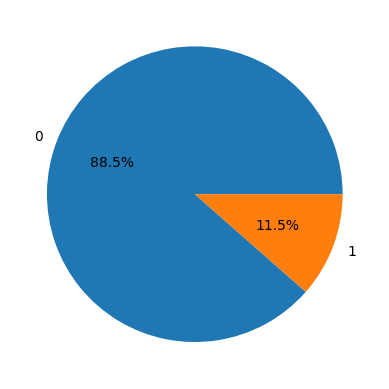

In [68]:
names, counts = np.unique(y, return_counts=True)
plt.pie(counts, labels=names, autopct='%1.1f%%');

In [69]:
from imblearn.over_sampling import SMOTE

In [13]:
sm = SMOTE()
X_over, y_over = sm.fit_resample(X, y)

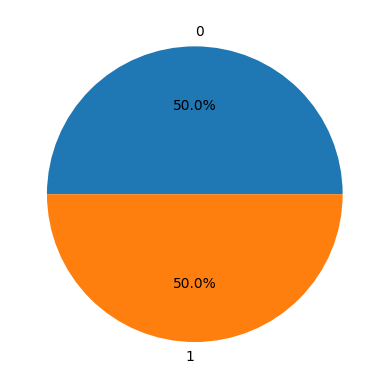

In [14]:
names, counts = np.unique(y_over, return_counts=True)
plt.pie(counts, labels=names, autopct='%1.1f%%');

In [70]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

In [71]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [72]:
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)

In [73]:
X_test_std = std_scaler.transform(X_test)

In [74]:
min_max_scaler = MinMaxScaler()
X_train_min_max = min_max_scaler.fit_transform(X_train)

In [75]:
X_test_min_max = min_max_scaler.transform(X_test)

In [21]:
import tensorflow.keras as k

In [48]:
model = k.Sequential([
    k.layers.Input((41,)),
    # k.layers.Dense(6, activation='tanh'),
    # k.layers.Dense(99, activation='relu'), 
    k.layers.Dense(2, activation='softmax')  
])

In [49]:
model.compile(optimizer=k.optimizers.Adam(learning_rate=10.), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [50]:
model.fit(X_train, y_train, epochs=0)

y_pred = [np.argmax(pred) for pred in model.predict(X_test)]

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step


In [51]:
model.get_weights()

[array([[ 0.11627561, -0.09272635],
        [ 0.03317547, -0.20547876],
        [ 0.1471706 , -0.02664587],
        [-0.04803348, -0.05778214],
        [ 0.05431148, -0.19860761],
        [-0.01100421, -0.09417346],
        [ 0.32533002,  0.22872716],
        [-0.10301915,  0.3537326 ],
        [-0.07499489,  0.28648376],
        [ 0.02635306, -0.32794893],
        [ 0.20889479, -0.07202813],
        [-0.34513906,  0.02999213],
        [-0.12203163, -0.02241081],
        [-0.08740315,  0.33814812],
        [-0.1439438 , -0.1929215 ],
        [-0.2905931 ,  0.3259738 ],
        [ 0.37246096, -0.07356548],
        [ 0.34769535,  0.00751325],
        [ 0.05542928,  0.1370089 ],
        [ 0.1774624 ,  0.3551013 ],
        [-0.22157532,  0.18935984],
        [-0.03923723, -0.19844232],
        [-0.24074107,  0.1488486 ],
        [-0.15866031, -0.17852865],
        [-0.06760535, -0.34236324],
        [ 0.173056  ,  0.27781284],
        [ 0.10223854, -0.18873551],
        [ 0.20914924, -0.084

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2215
           1       0.00      0.00      0.00      2215

    accuracy                           0.50      4430
   macro avg       0.25      0.50      0.33      4430
weighted avg       0.25      0.50      0.33      4430



d:\hack\pmifi-oniip-hack\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\hack\pmifi-oniip-hack\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\hack\pmifi-oniip-hack\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [91]:
from catboost import CatBoostRegressor
from scipy.special import expit

In [92]:
lr = CatBoostRegressor().fit(X_train_min_max, y_train)
y_pred = [np.round(pred) for pred in expit(lr.predict(X_test_min_max))]

Learning rate set to 0.058916
0:	learn: 0.3184398	total: 163ms	remaining: 2m 43s
1:	learn: 0.3178231	total: 167ms	remaining: 1m 23s
2:	learn: 0.3175022	total: 171ms	remaining: 56.9s
3:	learn: 0.3170422	total: 176ms	remaining: 43.7s
4:	learn: 0.3166091	total: 179ms	remaining: 35.7s
5:	learn: 0.3161539	total: 183ms	remaining: 30.4s
6:	learn: 0.3157968	total: 188ms	remaining: 26.6s
7:	learn: 0.3154914	total: 192ms	remaining: 23.9s
8:	learn: 0.3151881	total: 196ms	remaining: 21.6s
9:	learn: 0.3147642	total: 200ms	remaining: 19.8s
10:	learn: 0.3143228	total: 205ms	remaining: 18.4s
11:	learn: 0.3139502	total: 210ms	remaining: 17.3s
12:	learn: 0.3135669	total: 214ms	remaining: 16.3s
13:	learn: 0.3132411	total: 218ms	remaining: 15.4s
14:	learn: 0.3129800	total: 222ms	remaining: 14.6s
15:	learn: 0.3126561	total: 228ms	remaining: 14s
16:	learn: 0.3124126	total: 234ms	remaining: 13.5s
17:	learn: 0.3121250	total: 240ms	remaining: 13.1s
18:	learn: 0.3118609	total: 246ms	remaining: 12.7s
19:	learn: 

In [93]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.11      0.20      2215
           1       0.13      0.98      0.22       287

    accuracy                           0.21      2502
   macro avg       0.55      0.55      0.21      2502
weighted avg       0.88      0.21      0.20      2502

